#Feature Engineering

> Importing Libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pickle

import warnings
warnings.filterwarnings('ignore')

> Loading dataset

In [96]:
df=pd.read_csv('data/preprocessed_data.csv')
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0



- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking


> Let's check shape of dataset


In [97]:
df.shape

(49281, 14)

> Let's check information

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49281 entries, 0 to 49280
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49281 non-null  int64  
 1   sales_channel          49281 non-null  object 
 2   trip_type              49281 non-null  object 
 3   purchase_lead          49281 non-null  int64  
 4   length_of_stay         49281 non-null  int64  
 5   flight_hour            49281 non-null  int64  
 6   flight_day             49281 non-null  int64  
 7   route                  49281 non-null  object 
 8   booking_origin         49281 non-null  object 
 9   wants_extra_baggage    49281 non-null  int64  
 10  wants_preferred_seat   49281 non-null  int64  
 11  wants_in_flight_meals  49281 non-null  int64  
 12  flight_duration        49281 non-null  float64
 13  booking_complete       49281 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 5.3+ 

> Let's saperate categorical and numerical columns

In [99]:
Numerical_col =[feature for feature in df.columns if df[feature].dtype != 'O']
Categorical_col =[feature for feature in df.columns if df[feature].dtype == 'O']

print (f" We have {len(Numerical_col)} Numerical columns and they are: \n{Numerical_col}\n")
print (f" We have {len(Categorical_col)} Categorical columns and they are: \n{Categorical_col}")

 We have 10 Numerical columns and they are: 
['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete']

 We have 4 Categorical columns and they are: 
['sales_channel', 'trip_type', 'route', 'booking_origin']


> Need to Process the Categorical Columns for Model training

> Booking urgency - categorize purchase lead

In [100]:
bins=[0,7,30,90,180,np.inf]
labels=['last_minute', 'short_term', 'medium_term', 'long_term','very_long_term']

df['booking_urgency'] = pd.cut(df['purchase_lead'], bins=bins,labels=labels)

> Weekend flight indicator

In [101]:
df['is_weekend_flight'] = df['flight_day'].isin([6, 7]).astype(int)

> Flight time category

In [102]:
def categorize_flight_time(hour):
  if 5 <= hour < 12:
      return 'morning'
  elif 12 <= hour < 17:
      return 'afternoon'
  elif 17 <= hour < 21:
      return 'evening'
  else:
      return 'night'

df['flight_time_category'] = df['flight_hour'].apply(categorize_flight_time)

> Early morning or late night flights (less convenient times)

In [103]:
df['inconvenient_flight_time'] = df['flight_hour'].isin(list(range(0, 6)) + list(range(22, 24))).astype(int)

> Total add-ons requested

In [104]:
df['total_extras'] = (df['wants_extra_baggage'] + df['wants_preferred_seat'] +
                      df['wants_in_flight_meals'])

# Customer engagement level (more extras = more engaged)
df['high_engagement'] = (df['total_extras'] >= 2).astype(int)

# Premium customer indicator (wants multiple services)
df['is_premium_customer'] = (df['total_extras'] == 3).astype(int)

# No extras at all (potentially price-sensitive)
df['no_extras'] = (df['total_extras'] == 0).astype(int)

print("Behavioral Features Created:")
print("- total_extras")
print("- high_engagement")
print("- is_premium_customer")
print("- no_extras")

print(f"\nCustomers with all extras: {df['is_premium_customer'].sum()}")
print(f"Customers with no extras: {df['no_extras'].sum()}")

Behavioral Features Created:
- total_extras
- high_engagement
- is_premium_customer
- no_extras

Customers with all extras: 8613
Customers with no extras: 10344


> Route frequency (popular routes may have better completion rates)

In [105]:
route_counts = df['route'].value_counts()
df['route_frequency'] = df['route'].map(route_counts)

# Popular route indicator (top 25% of routes)

route_freq_threshold = df['route_frequency'].quantile(0.75)
df['is_popular_route'] = (df['route_frequency'] >= route_freq_threshold).astype(int)

> Group travel indicator

In [106]:
# Group travellers
df['is_group_travel'] = (df['num_passengers'] >= 3).astype(int)

# Solo traveler
df['is_solo_traveler'] = (df['num_passengers'] == 1).astype(int)


> Flight Haul

In [107]:
# Long haul flight (duration > 6 hours)
df['is_long_haul'] = (df['flight_duration'] > 6).astype(int)


> Trip type

In [108]:
# Short trip (stay <= 3 days)
df['is_short_trip'] = (df['length_of_stay'] <= 3).astype(int)

# Extended stay (stay > 14 days)
df['is_extended_stay'] = (df['length_of_stay'] > 14).astype(int)


> Trip complexity

In [109]:
# Trip complexity score (combination of factors)
df['trip_complexity'] = (
    df['is_group_travel'] * 1 +
    df['is_long_haul'] * 1 +
    df['is_extended_stay'] * 1 +
    (df['trip_type'] == 'CircleTrip').astype(int) * 2
)

print("Trip Complexity Features Created:")
print("- is_group_travel")
print("- is_solo_traveler")
print("- is_long_haul")
print("- is_short_trip")
print("- is_extended_stay")
print("- trip_complexity")

Trip Complexity Features Created:
- is_group_travel
- is_solo_traveler
- is_long_haul
- is_short_trip
- is_extended_stay
- trip_complexity


> Passengers per day of stay

In [110]:
df['passengers_per_day'] = df['num_passengers'] / (df['length_of_stay'] + 1)

# Planning ratio (how much in advance per day of stay)
df['planning_ratio'] = df['purchase_lead'] / (df['length_of_stay'] + 1)

# Duration per passenger
df['duration_per_passenger'] = df['flight_duration'] / df['num_passengers']

# Last minute complex booking (risky combination)
df['last_minute_complex'] = ((df['purchase_lead'] < 7) & (df['trip_complexity'] >= 2)).astype(int)

print("Interaction Features Created:")
print("- passengers_per_day")
print("- planning_ratio")
print("- duration_per_passenger")
print("- last_minute_complex")

Interaction Features Created:
- passengers_per_day
- planning_ratio
- duration_per_passenger
- last_minute_complex


## Encode Categorical Variables

> Create a copy for encoding

In [111]:
df_encoded = df.copy()

> Label encode categorical variables

In [112]:
label_encoders = {}
categorical_cols = ['sales_channel', 'trip_type', 'booking_urgency', 'flight_time_category']

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    print(f"\n{col}_encoded: {dict(zip(le.classes_, le.transform(le.classes_)))}\n")


sales_channel_encoded: {'Internet': np.int64(0), 'Mobile': np.int64(1)}


trip_type_encoded: {'CircleTrip': np.int64(0), 'OneWay': np.int64(1), 'RoundTrip': np.int64(2)}


booking_urgency_encoded: {'last_minute': np.int64(0), 'long_term': np.int64(1), 'medium_term': np.int64(2), 'short_term': np.int64(3), 'very_long_term': np.int64(4), nan: np.int64(5)}


flight_time_category_encoded: {'afternoon': np.int64(0), 'evening': np.int64(1), 'morning': np.int64(2), 'night': np.int64(3)}



In [113]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49281 entries, 0 to 49280
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   num_passengers                49281 non-null  int64   
 1   sales_channel                 49281 non-null  object  
 2   trip_type                     49281 non-null  object  
 3   purchase_lead                 49281 non-null  int64   
 4   length_of_stay                49281 non-null  int64   
 5   flight_hour                   49281 non-null  int64   
 6   flight_day                    49281 non-null  int64   
 7   route                         49281 non-null  object  
 8   booking_origin                49281 non-null  object  
 9   wants_extra_baggage           49281 non-null  int64   
 10  wants_preferred_seat          49281 non-null  int64   
 11  wants_in_flight_meals         49281 non-null  int64   
 12  flight_duration               49281 non-null  

> List all engineered features

In [114]:
engineered_features = [
    'is_weekend_flight', 'inconvenient_flight_time',
    'total_extras', 'high_engagement', 'is_premium_customer', 'no_extras',
    'is_group_travel', 'is_solo_traveler', 'is_long_haul',
    'is_short_trip', 'is_extended_stay', 'trip_complexity',
    'route_frequency', 'is_popular_route',
    'passengers_per_day', 'planning_ratio', 'duration_per_passenger', 'last_minute_complex',
    'sales_channel_encoded', 'trip_type_encoded', 'booking_urgency_encoded',
    'flight_time_category_encoded'
]

# Original numerical features to keep

original_features = [
    'num_passengers', 'purchase_lead', 'length_of_stay',
    'flight_hour', 'flight_day', 'flight_duration',
    'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals'
]

# All features for modeling
model_features = original_features + engineered_features

print(f"Total Original Features: {len(original_features)}")
print(f"Total Engineered Features: {len(engineered_features)}")
print(f"Total Features for Modeling: {len(model_features)}")



Total Original Features: 9
Total Engineered Features: 22
Total Features for Modeling: 31


> Display feature info

In [115]:
feature_summary = pd.DataFrame({
    'Feature': model_features,
    'Type': ['Original']*len(original_features) + ['Engineered']*len(engineered_features),
    'Non-Null': [df_encoded[f].notna().sum() for f in model_features],
    'Dtype': [df_encoded[f].dtype for f in model_features]
})
print(feature_summary)


                         Feature        Type  Non-Null    Dtype
0                 num_passengers    Original     49281    int64
1                  purchase_lead    Original     49281    int64
2                 length_of_stay    Original     49281    int64
3                    flight_hour    Original     49281    int64
4                     flight_day    Original     49281    int64
5                flight_duration    Original     49281  float64
6            wants_extra_baggage    Original     49281    int64
7           wants_preferred_seat    Original     49281    int64
8          wants_in_flight_meals    Original     49281    int64
9              is_weekend_flight  Engineered     49281    int64
10      inconvenient_flight_time  Engineered     49281    int64
11                  total_extras  Engineered     49281    int64
12               high_engagement  Engineered     49281    int64
13           is_premium_customer  Engineered     49281    int64
14                     no_extras  Engine

>  Calculate correlation with target

Top 15 Features by Absolute Correlation with Target:
is_extended_stay                        : -0.1173
flight_duration                         : -0.1065
trip_complexity                         : -0.1051
passengers_per_day                      : +0.0817
duration_per_passenger                  : -0.0763
wants_extra_baggage                     : +0.0685
total_extras                            : +0.0679
no_extras                               : -0.0622
is_long_haul                            : -0.0529
high_engagement                         : +0.0509
wants_preferred_seat                    : +0.0502
is_premium_customer                     : +0.0466
length_of_stay                          : -0.0421
sales_channel_encoded                   : -0.0393
route_frequency                         : +0.0374


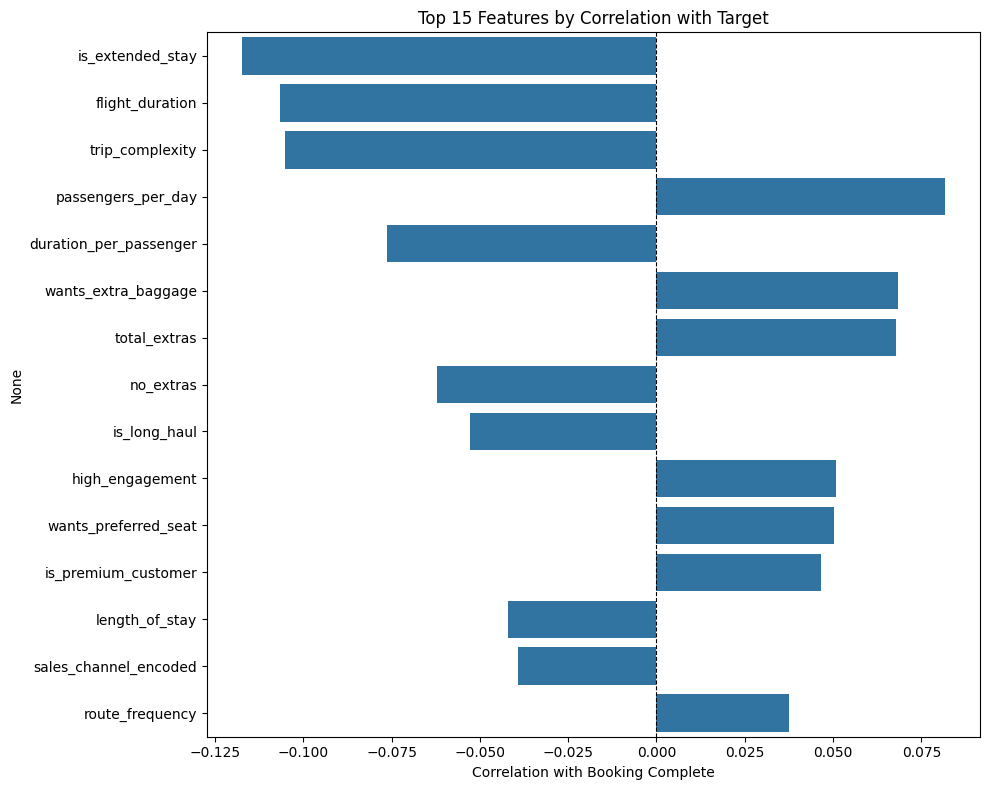

In [116]:
correlations = df_encoded[model_features + ['booking_complete']].corr()['booking_complete'].drop('booking_complete')
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Display top correlations
print("Top 15 Features by Absolute Correlation with Target:")
print("="*60)
for feature, corr_val in correlations_sorted.head(15).items():
    actual_corr = correlations[feature]
    print(f"{feature:40s}: {actual_corr:+.4f}")

# Visualize top correlations
plt.figure(figsize=(10, 8))
top_features = correlations_sorted.head(15).index
sns.barplot(x=correlations[top_features].values, y=top_features)
plt.xlabel('Correlation with Booking Complete')
plt.title('Top 15 Features by Correlation with Target')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

> Check missing values

In [117]:
missing_values = df_encoded[model_features].isnull().sum()

if missing_values.sum() > 0:
    print("Missing Values:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values in feature set")


No missing values in feature set


> Check for infinite values

In [118]:
inf_check = np.isinf(df_encoded[model_features].select_dtypes(include=[np.number])).sum()
if inf_check.sum() > 0:
    print("\nInfinite Values:")
    print(inf_check[inf_check > 0])
else:
    print("No infinite values in feature set")


No infinite values in feature set


> Basic statistics

In [119]:
print("\nFeature Statistics:")
print(df_encoded[model_features].describe().T[['mean', 'std', 'min', 'max']])


Feature Statistics:
                                    mean         std       min     max
num_passengers                  1.590187    1.016538  1.000000     9.0
purchase_lead                  84.723281   90.410229  0.000000   867.0
length_of_stay                 23.053976   33.832149  0.000000   778.0
flight_hour                     9.070676    5.413099  0.000000    23.0
flight_day                      3.813620    1.991913  1.000000     7.0
flight_duration                 7.279974    1.496390  4.670000     9.5
wants_extra_baggage             0.668229    0.470854  0.000000     1.0
wants_preferred_seat            0.295631    0.456331  0.000000     1.0
wants_in_flight_meals           0.426635    0.494593  0.000000     1.0
is_weekend_flight               0.246850    0.431183  0.000000     1.0
inconvenient_flight_time        0.323350    0.467760  0.000000     1.0
total_extras                    1.390495    1.003679  0.000000     3.0
high_engagement                 0.425620    0.494442  0.

> Prepare final dataset

In [120]:
final_columns = model_features + ['booking_complete']
df_final = df_encoded[final_columns].copy()

# Save to CSV
df_final.to_csv('data/customer_booking_featured.csv', index=False)
print(f"# Processed dataset saved: customer_booking_featured.csv")
print(f"  Shape: {df_final.shape}")
print(f"  Features: {len(model_features)}")
print(f"  Target: booking_complete")

# Also save feature names and encoders for future use


feature_info = {
    'model_features': model_features,
    'original_features': original_features,
    'engineered_features': engineered_features,
    'label_encoders': label_encoders
}

with open('model/feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)

print("\n Feature information saved: feature_info.pkl")

# Processed dataset saved: customer_booking_featured.csv
  Shape: (49281, 32)
  Features: 31
  Target: booking_complete

 Feature information saved: feature_info.pkl
